# <span style="color:#ff4238;">__DATA 200 FINAL Project__</span>

#### Authors: Brandon Chan, Lucas Duncan, Owen Macgowan, Brayden Van De Wynckel

#### Date: April 2024

![Friends](https://qph.cf2.quoracdn.net/main-qimg-55f2935b1d162eb07783e02013ca66e9-lq)

---
## <span style="color:#42a2d6;">__Summary of Contents__</span>
#### __Our Final project will build on our midterm and cover the following topics:__
1. Background and Purpose
2. Research Question
3. Importing Data
4. Processing Data
5. Inference
6. Prediction Task
7. Regression + Classification

# <span style="color:#f6be00;">__1. Background and Purpose__</span>
In this project, we will delve into datasets that contain detailed information about the content and tone of dialogue spoken by the six main members of the Friends cast. 

Our focus will be examining the ratio of dialogue between both main and side characters, as
well as exclamatory speech by them, whether indicated by exclamation marks or capital letters denoting shouting or excitement. 

Our goal is to explore whether a correlation exists between the overall use of exclamation, its distribution among different characters, its frequency overall and its frequency by non main characters overall, to predict the resulting episode rating and viewership. This analysis will shed light on the impact of emphatic dialogue on the reception and popularity of each episode.

## <span style="color:#f6be00;">__2 Research Question__</span>
### How does the frequency of exclamation, and overall trends in speech frequency from characters in the series friends correlate with viewership numbers and ratings across episodes.

.......................................................................



# <span style="color:#ff4238;">__3. Imports__</span>
#### This section imports all of the required components for data cleaning, visualization, and modeling.

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

import sklearn.metrics as sklm

In [109]:
dialogue = pd.read_csv(("https://raw.githubusercontent.com/"
 "rfordatascience/tidytuesday/master/data/"
 "2020/2020-09-08/friends.csv"))

print("Example Dialogue:")
dialogue.sample(4)


Example Dialogue:


,text,speaker,season,episode,scene,utterance
9803,"I don't know, I don't get, I don't get it, I m...",Ross Geller,2,14,3,6
60788,"Right, right, right, well, she wants to go to ...",Joey Tribbiani,9,21,6,14
4603,"..ah, what're you doing here? I've been trying...",Joey Tribbiani,1,17,12,4
5832,"Yeah, yeah. They even do you.",Phoebe Buffay,1,22,5,24


In [110]:
episodes = pd.read_csv(("https://raw.githubusercontent.com/"
 "rfordatascience/tidytuesday/master/data/"
 "2020/2020-09-08/friends_info.csv"))

print("Example Episode:")
episodes.sample(4)

Example Episode:


,season,episode,title,directed_by,written_by,air_date,us_views_millions,imdb_rating
180,8,11,The One with Ross's Step Forward,Gary Halvorson,Robert Carlock,2001-12-13,23.85,8.0
177,8,8,The One with the Stripper,David Schwimmer,Andrew Reich & Ted Cohen,2001-11-15,26.54,8.8
102,5,6,The One with the Yeti,Gary Halvorson,Alexa Junge,1998-11-05,25.00,8.1
192,8,23,The One Where Rachel Has a Baby,Kevin S. Bright,Scott SilveriMarta Kauffman & David Crane,2002-05-16,34.91,8.8


# <span style="color:#42a2d6;">__4. Data Processing__</span>
#### In this section, we use regex, pivoting, filtering, and joining to create a dataframe with both Target Variables (rating, and viewership) as well as character and episode specific verbal occurances, both exclamatory and otherall.

In [111]:


# 6 Main Character Names
main_character_names = ["Ross Geller", "Monica Geller",
                        "Phoebe Buffay", "Chandler Bing",
                        "Joey Tribbiani", "Rachel Green"]


#Filters Out Non Dialogue Rows
all_dialogue = dialogue[~dialogue["speaker"].isin(["Scene Directions", "#ALL#", "NA"])]


#Indexs of  MAIN CHARACTER DIALOGUE
dialogue_mc_indexs = all_dialogue["speaker"].isin(main_character_names)

#Indexs of OTHER CHARACTER DIALOGUE
dialogue_oc_indexs = ~all_dialogue["speaker"].isin(main_character_names)

#Indexs of EXCLAMATORY DIALOGUE
dialogue_exclamatory_indexs = all_dialogue["text"].str.contains(r'[A-Z]{2,}') | all_dialogue["text"].str.contains(r'!')

In [112]:
#FUNCTION TO APPLY

def sum_size(x):
    return x.str.len().sum()


def normalize_column(series):
    
    mean = series.mean()
    std = series.std()
    
    # Normalize the Series
    series_normalized = (series - mean) / std
    
    return series_normalized
                      

### Processing 1/4: Adding Info About Total Speech Patterns Within Each Episode


In [113]:

#Table To Store Episode Level Dialogue Summary
jt_1 = all_dialogue.groupby(["season", "episode"]).agg("first").reset_index().drop(columns=["scene", "utterance", "speaker", "text"])

jt_1.head(2)

,season,episode
0,1,1
1,1,2


In [114]:
#Grouped Data
gp = all_dialogue.groupby(["season", "episode"])

#Adding Total Lines In Episode
jt_1 = pd.merge(jt_1, gp["text"].agg(sum_size).reset_index(name="total_lines"))

#Adding Total Speakers In Episode
jt_1 = pd.merge(jt_1, gp["speaker"].nunique().reset_index(name="total_speakers"))

jt_1.head(5)

,season,episode,total_lines,total_speakers
0,1,1,16876,11
1,1,2,12249,14
2,1,3,12070,10
3,1,4,12532,14
4,1,5,12626,10


In [115]:

#Grouped Data (All NON-MAIN Characters Lines By Episodes)
gp = all_dialogue[dialogue_oc_indexs].groupby(["season", "episode"])


# Adding Total Lines By NON-MAIN characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_lines"))


#Grouped Data (All NON-MAIN Characters Exclamatory Lines By Episode)
gp = all_dialogue[dialogue_oc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode"])

#Adding Total Exclamatory Lines By Non Main Characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_exclam"))

jt_1.head(5)

,season,episode,total_lines,total_speakers,oc_lines,oc_exclam
0,1,1,16876,11,27,5
1,1,2,12249,14,69,19
2,1,3,12070,10,24,3
3,1,4,12532,14,31,10
4,1,5,12626,10,34,2


### Processing 2/4: Adding Character Level Dialogue Info

In [116]:
#Table To Store Character Level Dialogue Summary
# (WILL BE PIVOTED INTO ABOVE FORM BELOW)

jt_2 = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"]).agg("first").reset_index().drop(columns=["scene", "utterance", "text"])

jt_2.head(6)

,season,episode,speaker
0,1,1,Chandler Bing
1,1,1,Joey Tribbiani
2,1,1,Monica Geller
3,1,1,Phoebe Buffay
4,1,1,Rachel Green
5,1,1,Ross Geller


In [117]:
#Grouped Data (All Main Character Dialogue By Episode, Speaker)
gp = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"])

#Adding Total Lines Per Main Character
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="lines"))

#Grouped Data (All Main Character Exclamatory Lines, By Episode, Speaker)
gp = all_dialogue[dialogue_mc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode", "speaker"])

#Adding Total Exclamatory Lines By Main Character
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="exclam_lines"))


jt_2.head(6)

,season,episode,speaker,lines,exclam_lines
0,1,1,Chandler Bing,39,8
1,1,1,Joey Tribbiani,39,11
2,1,1,Monica Geller,73,20
3,1,1,Phoebe Buffay,19,5
4,1,1,Rachel Green,48,15
5,1,1,Ross Geller,47,8


In [119]:

#Pivoting Table (To Ensure One Row Per Episode)
jt_2 = jt_2.pivot(index=["season", "episode"], columns="speaker", values=["lines", "exclam_lines"]).reset_index(inplace=False)

#Renaming Columns + Reseting Index
jt_2.columns = ['_'.join(map(str, col)).strip() for col in jt_2.columns.values]
jt_2.reset_index(inplace=False)
jt_2.rename(columns={"season_":"season", "episode_":"episode"}, inplace=True)


jt_2.head(2)

,season,episode,lines_Chandler Bing,lines_Joey Tribbiani,lines_Monica Geller,lines_Phoebe Buffay,lines_Rachel Green,lines_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller
0,1,1,39.0,39.0,73.0,19.0,48.0,47.0,8.0,11.0,20.0,5.0,15.0,8.0
1,1,2,16.0,8.0,28.0,14.0,38.0,68.0,2.0,1.0,5.0,9.0,8.0,10.0


### Processing 3/4: Adding Episode Review/Viewership Info (Target Variables)

In [120]:
#Taking Existing Episode df and dropping certain attributes
jt_3 = episodes.drop(columns=["title", "directed_by", "written_by", "air_date"])

jt_3.head(6)

,season,episode,us_views_millions,imdb_rating
0,1,1,21.5,8.3
1,1,2,20.2,8.1
2,1,3,19.5,8.2
3,1,4,19.7,8.1
4,1,5,18.6,8.5
5,1,6,18.2,8.1


### Processing 4/4: Joining Tables + Summary

In [121]:
#JOINING ALL STATISTICS INTO A SINGLE DATA TO CREATE A MODEL FROM

joined_table_final = pd.merge(pd.merge(jt_1, jt_2, on=["season", "episode"]), jt_3, on=["season", "episode"])

joined_table_final.head(2)

,season,episode,total_lines,total_speakers,oc_lines,oc_exclam,lines_Chandler Bing,lines_Joey Tribbiani,lines_Monica Geller,lines_Phoebe Buffay,lines_Rachel Green,lines_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller,us_views_millions,imdb_rating
0,1,1,16876,11,27,5,39.0,39.0,73.0,19.0,48.0,47.0,8.0,11.0,20.0,5.0,15.0,8.0,21.5,8.3
1,1,2,12249,14,69,19,16.0,8.0,28.0,14.0,38.0,68.0,2.0,1.0,5.0,9.0,8.0,10.0,20.2,8.1


# <span style="color:#42a2d6;">__5. Inference Task __</span>
#### ...... SUMMARY TO BE FILLED IN................

In [ ]:
# I want to verify that use of exclamatory speech really does impact episode IMDb rating 

# Resampling import to use in bootstrapping 
from sklearn.utils import resample

# Combining columns with exclamation
exclam_cols = ['exclam_lines_Chandler Bing','exclam_lines_Joey Tribbiani','exclam_lines_Monica Geller','exclam_lines_Phoebe Buffay','exclam_lines_Rachel Green','exclam_lines_Ross Geller']
exclam = joined_table_final['oc_exclam'] 
for col_name in exclam_cols:
    exclam = exclam + joined_table_final.loc[:,col_name]

# Creates new dataframe with the desired columns (rating and # of exclamations)
df_exclam = pd.DataFrame({"Exclamations":exclam, "Rating":joined_table_final['imdb_rating']})
mean_exclam = np.round(np.mean(df_exclam), 0)
df_exclam.fillna({'Exclamations':mean_exclam}, inplace=True)

# Defines two populations: IMDb ratings with high exclamation use and ratings with low exclamation use 
df_exclam 
mean_exclamation = np.mean(df_exclam['Exclamations'])
pop1 = df_exclam[df_exclam['Exclamations']>mean_exclamation]['Rating']
pop2 = df_exclam[df_exclam['Exclamations']<=mean_exclamation]['Rating']

# Define number of bootstrap resamples
n_resamples = 1000
mean_diffs = np.zeros(n_resamples)

# Bootstrapping procedure (add difference in each resampled mean to the list)
for i in range(n_resamples):
    s1 = resample(pop1, replace=True)
    s2 = resample(pop2, replace=True)
    mean_diffs[i] = np.mean(s1)-np.mean(s2) 
    
# Confidence interval 
ci_95 = np.percentile(mean_diffs, [2.5, 97.5]) 

# Mean Difference 
mean_difference = round(np.mean(mean_diffs),2)

print(f'On average, episodes with more exclamation have about {mean_difference*100}% higher imdb ratings.')
print(f'The mean difference between ratings is on a 95% confidence interval of being in the range({round(ci_95[0],2)*100}%, {round(ci_95[1],2)*100}%)')


On average, episodes with more exclamation have about 13.0% higher imdb ratings.
The mean difference between ratings is on a 95% confidence interval of being in the range(3.0%, 22.0%)


It seems that the hypothesis was correct. Episodes with more exclamatory speech tend to have **13%** higher ratings on average! This clearly demonstrates that emphatic speech significantly impacts episode IMDb rating.    

# <span style="color:#42a2d6;">__6. Prediction Task + Cross Validation__</span>
#### ........... SUMMARY ...................

In [122]:

joined_table_final = joined_table_final.dropna()

# Separate features and target variables
x_cols = joined_table_final.drop(["us_views_millions", "imdb_rating"], axis=1)
y_views = normalize_column(pd.Series(joined_table_final['us_views_millions']))
y_rating = normalize_column(pd.Series(joined_table_final['imdb_rating']))


# Split data for views prediction
X_train_view, X_test_view, y_train_view, y_test_view = train_test_split(x_cols, y_views, test_size=0.10) 

# Split data for ratings prediction
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(x_cols, y_rating, test_size=0.10)

# Scale data for views prediction
scaler = StandardScaler()
X_train_view_scaled = scaler.fit_transform(X_train_view)
X_test_view_scaled = scaler.transform(X_test_view)

# Scale data for ratings prediction
X_train_rate_scaled = scaler.fit_transform(X_train_rate)
X_test_rate_scaled = scaler.transform(X_test_rate)



In [123]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) 

#Find Ideal Alpha For View Prediction
model_ridge_cv_views = RidgeCV(alphas=np.arange(0.01, 1000, 1), cv=cv, scoring='neg_mean_absolute_error') 
model_ridge_cv_views.fit(X_train_view_scaled, y_train_view)
view_ideal_alpha = model_ridge_cv_views.alpha_

#Find Ideal Alhpa For Rating Prediction
model_ridge_cv_ratings = RidgeCV(alphas=np.arange(0.01, 1000, 1), cv=cv, scoring='neg_mean_absolute_error') 
model_ridge_cv_ratings.fit(X_train_rate_scaled, y_train_rate)
rate_ideal_alpha = model_ridge_cv_ratings.alpha_

print("Ideal alpha for views prediction:", view_ideal_alpha)
print("Ideal alpha for ratings prediction:", rate_ideal_alpha)

Ideal alpha for views prediction: 150.01
Ideal alpha for ratings prediction: 184.01


In [124]:


model_for_view = Ridge(alpha=view_ideal_alpha)
model_for_view = model_for_view.fit(X_train_view_scaled, y_train_view)
print(f'MSE VIEW MODEL: {sklm.mean_squared_error(y_test_view, model_for_view.predict(X_test_view_scaled))}')


model_for_rate = Ridge(alpha=rate_ideal_alpha)
model_for_rate = model_for_rate.fit(X_train_rate_scaled, y_train_rate)
print(f'MSE RATE MODEL: {sklm.mean_squared_error(y_test_rate, model_for_rate.predict(X_test_rate_scaled))}')


view_coefficients = pd.Series(model_for_view.coef_, index=X_train_rate.columns)
rate_coefficients = pd.Series(model_for_rate.coef_, index=X_train_rate.columns)

MSE VIEW MODEL: 0.5059275635394809
MSE RATE MODEL: 1.1274298492014516


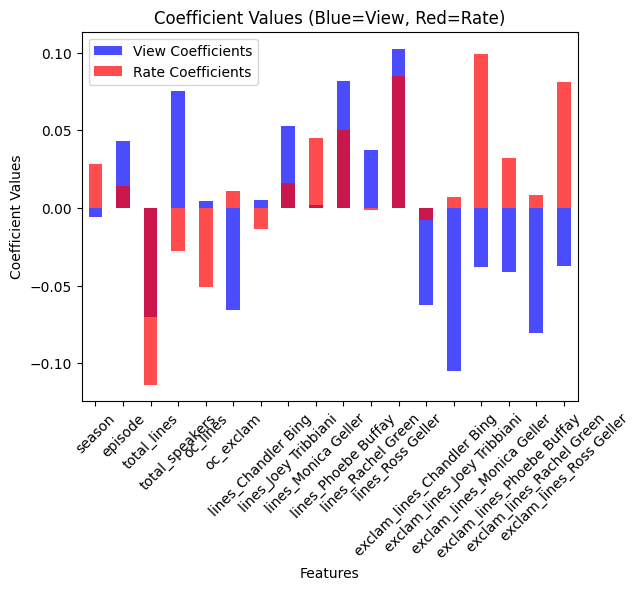

In [125]:
view_coefficients.plot(kind='bar', color='blue', alpha=0.7, label='View Coefficients')
rate_coefficients.plot(kind='bar', color='red', alpha=0.7, label='Rate Coefficients', position=0.5)

plt.xlabel('Features')
plt.ylabel('Coefficient Values')
plt.title('Coefficient Values (Blue=View, Red=Rate)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# <span style="color:#42a2d6;">__7. Regression and Classification__</span>
#### ...........SUMMARY TO BE ADDED........

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Split the data into training and testing sets
X = joined_table_final.loc[:, joined_table_final.columns != 'speaker'].reset_index(drop=True)
y = joined_table_final[['imdb_rating']].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # Alpha is the regularization parameter
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)

# Lasso Regression
lasso_reg = Lasso(alpha=1.0)  # Alpha is the regularization parameter
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(lasso_mse)

ridge_coefficients = ridge_reg.coef_
lasso_coefficients = lasso_reg.coef_

# Plot Ridge coefficients
plt.plot(range(len(ridge_coefficients)), ridge_coefficients, label='Ridge Coefficients')

# Plot Lasso coefficients
plt.plot(range(len(lasso_coefficients)), lasso_coefficients, label='Lasso Coefficients')

plt.xlabel('Coefficients index')
plt.ylabel('Coefficients magnitude')
plt.legend()
plt.show()

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# Actual vs Predicted plot for Ridge
plt.scatter(y_test, ridge_pred, label='Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Actual vs Predicted plot for Lasso
plt.scatter(y_test, lasso_pred, label='Lasso Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.94      1.00      0.97       252

    accuracy                           0.94       268
   macro avg       0.47      0.50      0.48       268
weighted avg       0.88      0.94      0.91       268

[[  0  16]
 [  0 252]]


c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.p

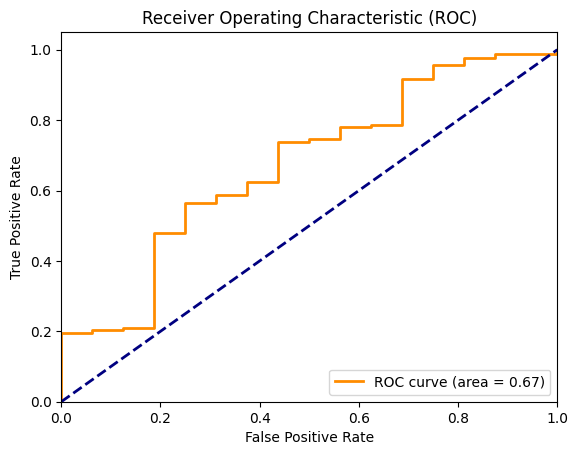

c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.94      1.00      0.97       252

    accuracy                           0.94       268
   macro avg       0.47      0.50      0.48       268
weighted avg       0.88      0.94      0.91       268



c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


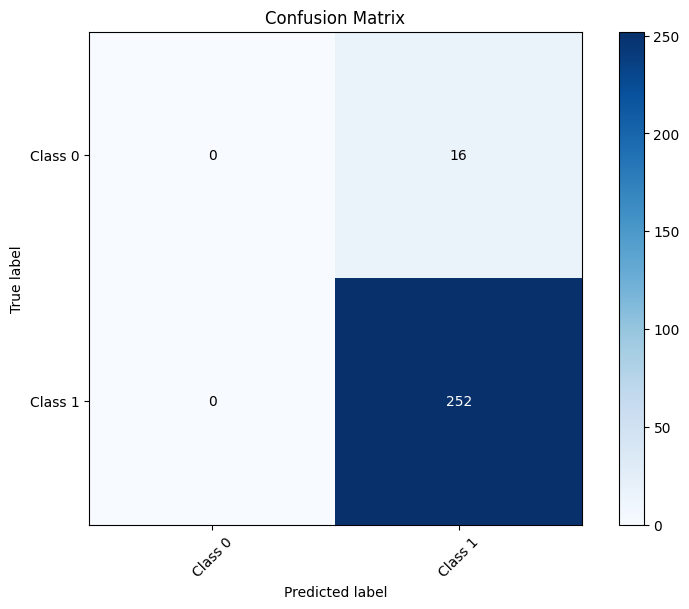

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
joined_table_final['high_rating'] = np.where(joined_table_final['imdb_rating'] > 8.0, 1, 0)

# Define the features and the target.
X = joined_table_final.loc[:, joined_table_final.columns != 'speaker']
X = X.drop(['imdb_rating', 'high_rating'], axis=1)  # Drop the original 'imdb_rating' and the new binary target column from the features.
y = joined_table_final['high_rating']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier.
log_reg = LogisticRegression()

# Fit the classifier to the training data.
log_reg.fit(X_train, y_train)

# Predict on the testing set.
y_pred = log_reg.predict(X_test)

# Evaluate the classifier.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Assume log_reg is your trained Logistic Regression model, and X_test and y_test are your test dataset.

# Get predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Display the classification report
print(classification_report(y_test, log_reg.predict(X_test)))

# Compute and plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming log_reg is your trained Logistic Regression model
# and y_test, y_pred are your test labels and predictions respectively

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding the text labels
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2. # for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")  # text color

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# <span style="color:#42a2d6;">__6. Conclusions__</span>

..... TO BE ADDED ......